# Evaluating selected cells for COVID-19 severity regression
***
Jan T. Schleicher, 2022

In this notebook, we evaluate the selected cells for disease severity regression of healthy donors and COVID-19 patients. This analysis is based on the data from [Wilk et al. 2021](https://doi.org/10.1084/jem.20210582).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.legend_handler import HandlerTuple
from matplotlib import patheffects as pe
import seaborn as sns
from scipy import stats
import os

import enrichment_plots as ep

%config Completer.use_jedi = False
%matplotlib inline
sns.set_theme(style="ticks", font_scale=1.2)

In [2]:
plot_dir = "../output/figures/blish_severity"
os.makedirs(plot_dir, exist_ok=True)

## Plot RMSEs

To choose the best input dimensionality for our model, i.e., the best number of principal components, we look at the root mean square errors (RMSE) across three random splits of the data.

In [3]:
rmses = pd.read_csv("../output/model_evaluations/blish_severity_RMSE.csv")
rmses.n_PCs = rmses.n_PCs.astype(str)
rmses_long = pd.melt(rmses, id_vars="n_PCs", var_name="rmse_type", value_name="rmse")
rmses_long["rmse_type"] = rmses_long["rmse_type"].str.replace("_RMSE", "")

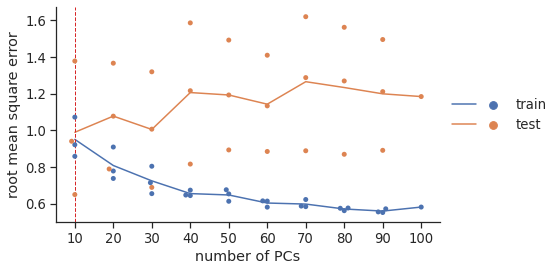

In [4]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="n_PCs", y="rmse", data=rmses_long, ax=ax, ci=None,
             hue="rmse_type", hue_order=["train", "test"])
sns.swarmplot(x="n_PCs", y="rmse", data=rmses_long, ax=ax,
              hue="rmse_type", hue_order=["train", "test"])
sns.despine()
ax.axvline("10", ls="--", lw=1, c="tab:red")
ax.set_xlabel("number of PCs")
ax.set_ylabel("root mean square error")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=["train", "test"], loc="center left", handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)},
          frameon=False, bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, "blish_severity_rmses.svg"), dpi=200);

## Loading data

We import the filter response from the CellCnn model for regression of disease severity in the COVID-19 data ([Wilk et al. 2021](https://doi.org/10.1084/jem.20210582)). According to the performance evaluation shown above, this is the model that uses 10 principal components as input. We evaluate the model trained on the first training split of the data. The evaluation is performed on training and test data together.

In [5]:
filter_response = pd.read_csv("../output/filter_responses/blish_severity_filter_response.csv",
                             index_col=0)
response_data = pd.read_csv("../data/blish_response_data.csv")
filter_response = filter_response.merge(response_data[["Donor", "current_severity"]], on="Donor")
meta_data_umap = pd.read_csv("../data/blish_meta_data_umap.csv")
filter_response = filter_response.merge(meta_data_umap[["cell.name", "cell.type.fine", "cell.type.coarse",
                                                        "UMAP_1", "UMAP_2"]], on="cell.name")
filter_response

,Donor,cell.type,cell.name,data_set,response_filter_0,response_filter_1,current_severity,cell.type.fine,cell.type.coarse,UMAP_1,UMAP_2
0,28205-0555d0,Platelet,555_1.100_AAAGAATTACGG,train,-0.679012,-2.779757,5,Platelet,Platelet,-0.334269,-0.747272
1,28205-0555d0,CD4 TCM,555_1.1000_CAATCGGTTGCG,train,0.664365,-0.573956,5,ISG+ CD14 mono,CD14 mono,-10.161209,1.864213
2,28205-0555d0,Plasmablast,555_1.1001_TCGGCGCTTACA,train,1.493410,-1.547473,5,IgA PB,PB,-1.661245,-6.138116
3,28205-0555d0,Eryth,555_1.1002_CCCGGCGCGTAC,train,0.802013,-0.743386,5,IgG PB,PB,-10.340357,2.079315
4,28205-0555d0,CD14 Mono,555_1.1003_GGTAGTCAATAC,train,2.351928,-1.007162,5,ISG+ CD14 mono,CD14 mono,-11.524545,1.723889
...,...,...,...,...,...,...,...,...,...,...,...
94434,55689-0061,CD14 Mono,Imm_061.986_TTACGGATGAAC,test,0.442945,0.235063,2,CD14 mono,CD14 mono,-7.217625,2.144411
94435,55689-0061,CD16 Mono,Imm_061.987_AGGGAATCTGTA,test,-0.389102,0.149233,2,CD16 mono,CD16 mono,-7.066542,5.743073
94436,55689-0061,CD14 Mono,Imm_061.992_CACGGCTCTGGC,test,-0.390413,0.963573,2,CD14 mono,CD14 mono,-7.039715,2.469521
94437,55689-0061,CD8 Naive,Imm_061.997_AATCGCGGGGGG,test,-0.616522,0.004379,2,CD4 T,CD4 T,6.466684,-2.365980


## Computing selected cell frequencies per sample

We compute the frequencies of cells with a positive filter response per sample. From this, we generate a plot of selected cell frequencies versus disease severity.

In [6]:
# mark cells with positive filter response as selected
selected_cells_df = filter_response[["Donor", "current_severity", "data_set"]].copy()
selected_cells_df = selected_cells_df.merge(filter_response.filter(regex="response_filter_\d*$"),
                                            left_index=True, right_index=True)
selected_cells_df.rename(columns={"current_severity": "severity"}, inplace=True)
for i, col in enumerate(selected_cells_df.filter(regex="response_filter_\d*$").columns):
    selected_cells_df[f"selected_filter_{i}"] = (selected_cells_df[col] > 0)
    
# count selected and total cells per sample
total_cell_counts = selected_cells_df.groupby(["Donor", "severity", "data_set"], observed=True)\
    .size().reset_index(name="count")
selected_cell_counts = selected_cells_df.groupby(["Donor", "severity"], observed=True).sum()\
    .filter(regex="selected_filter_\d*$").reset_index()\
    .merge(total_cell_counts, on=["Donor", "severity"])

# compute selected cell frequencies per sample
for col in selected_cell_counts.filter(regex="selected_filter_\d*$").columns:
    selected_cell_counts[col + "_freq"] = selected_cell_counts[col] / selected_cell_counts["count"] * 100
display(selected_cell_counts)

,Donor,severity,selected_filter_0,selected_filter_1,data_set,count,selected_filter_0_freq,selected_filter_1_freq
0,28205-0555d0,5,2363,521,train,3657,64.615805,14.246650
1,28205-0555d2,7,3242,1396,train,5587,58.027564,24.986576
2,28205-0556,4,775,412,test,1816,42.676211,22.687225
3,28205-0557,7,2955,1060,test,5503,53.697983,19.262221
4,28205-0558,7,3285,477,train,4249,77.312309,11.226171
5,28205-0559,4,1673,151,train,2350,71.191489,6.425532
6,28205-0561,4,1936,1577,test,3079,62.877558,51.217928
7,28205-0563,4,2345,420,test,3540,66.242938,11.864407
8,28205-0565,4,2835,1305,train,6417,44.179523,20.336606
9,28205-0566,5,3947,290,train,5884,67.080218,4.928620


Selected cell frequencies for filter 0


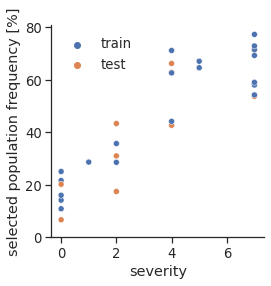

Selected cell frequencies for filter 1


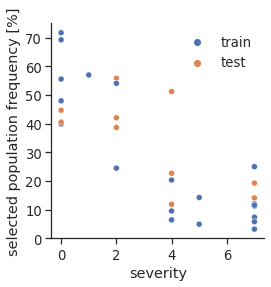

In [7]:
for i, col in enumerate(selected_cell_counts.filter(regex="selected_filter_\d*_freq").columns):
    print(f"Selected cell frequencies for filter {i}")
    ep.plot_selected_cell_frequencies_regression(selected_cells=selected_cell_counts,
                                                 response_col="severity", hue="data_set",
                                                 filter_idx=i, save=True, out_dir=plot_dir)

## Predicted vs. true response

For regression, we look at the predicted response compared to the true values.

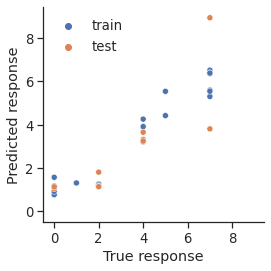

In [8]:
predictions = pd.read_csv("../output/model_evaluations/blish_severity_predictions.csv", index_col=0)

fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(x="true", y="pred", data=predictions, hue="data_set")
ax.set_ylabel("Predicted response")
ax.set_xlabel("True response")
ax.legend(loc="upper left", frameon=False)

min_val = min(predictions.true.min(), predictions.pred.min())
max_val = max(predictions.true.max(), predictions.pred.max())
ax.set_xlim(min_val-.5, max_val+.5)
ax.set_ylim(min_val-.5, max_val+.5)

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(plot_dir, "blish_severity_predicted_vs_response.svg"))

## Create UMAP plots with filter response

Next, we visualize the cell-wise filter response on the UMAP projection of the data

In [9]:
filter_response[filter_response.filter(regex="response_filter_\d*$").columns] = \
    filter_response.filter(regex="response_filter_\d*$") *\
    (filter_response.filter(regex="response_filter_\d*$") > 0)

UMAP with filter response for filter 0


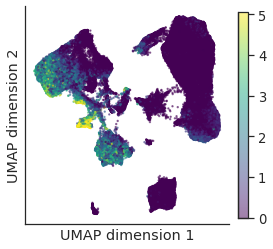

UMAP with filter response for filter 1


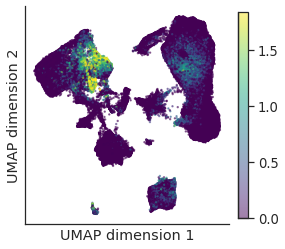

In [10]:
for i, col in enumerate(filter_response.filter(regex="response_filter_\d*$").columns):
    print(f"UMAP with filter response for filter {i}")
    fig, ax = plt.subplots(figsize=(4, 4))

    im = ax.scatter(filter_response["UMAP_1"], filter_response["UMAP_2"], c=filter_response[col],
                    vmin=0, vmax=np.percentile(filter_response[col], 99), cmap="viridis",
                    alpha=.5, edgecolors="face", s=2)
    im.set_rasterized(True)
    plt.colorbar(im, fraction=.046, pad=.04)
    ax.set(xlabel="UMAP dimension 1", ylabel="UMAP dimension 2", xticks=[], yticks=[])
    sns.despine()
    plt.show()
    fig.savefig(os.path.join(plot_dir, f"umap_filter_{i}.svg"), dpi=200)

## Enriched cell types

In the next step, we look at the frequencies and enrichments of different cell types in the selected cells. The threshold for selected cells for each filter is $0.3 \times (\text{maximum filter response})$.

In [11]:
cell_type_coarse_colors = {"CD4 T": "#F8766D", "CD8 T": "#E38900", "Platelet": "#C49A00",
                           "Neutrophil": "#99A800", "NK": "#53B400", "B": "#00BC56",
                           "PB": "#00C094", "CD14 mono": "#00BFC4", "Developing neutrophil": "#00B6EB",
                           "CD16 mono": "#06A4FF", "Eos/Mast Prog": "#A58AFF",
                           "Prolif Lymph": "#DF70F8", "DC": "#FB61D7", "pDC": "#FF66A8"}

Selected cell type enrichments for filter 0


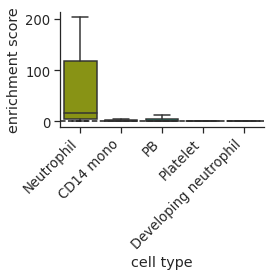

Selected cell type enrichments for filter 1


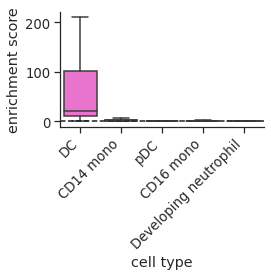

In [12]:
ep.enrichment_per_sample(filter_response, class_col=None, sample_col="Donor",
                         color_dict=cell_type_coarse_colors, figsize=(4,4), save=True,
                         cell_type_col="cell.type.coarse", ratio_max_response=.3, out_dir=plot_dir)

Selected cell type frequencies for filter 0


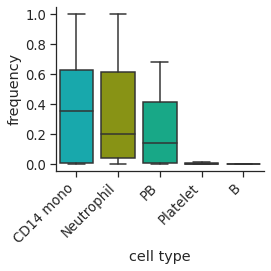

Selected cell type frequencies for filter 1


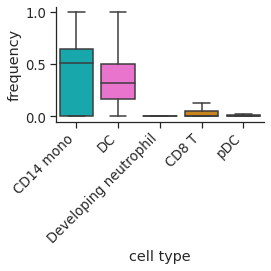

In [13]:
ep.frequency_per_sample(filter_response, class_col=None, sample_col="Donor",
                        color_dict=cell_type_coarse_colors, figsize=(4,4), save=True,
                        cell_type_col="cell.type.coarse", ratio_max_response=.3, out_dir=plot_dir)

### Pie charts selected proportion of cell type

Additionally, we also show the proportion of cells of a cell type that were selected for the two most frequently selected cell types for the first and second filter.

Proportion of cells selected by filter 0 for cell type 'CD14 mono' (out of all cells of this cell type)


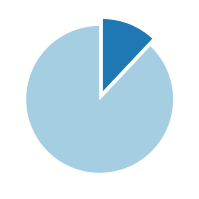

Proportion of cells selected by filter 0 for cell type 'Neutrophil' (out of all cells of this cell type)


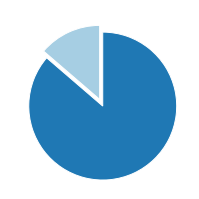

Proportion of cells selected by filter 0 for cell type 'PB' (out of all cells of this cell type)


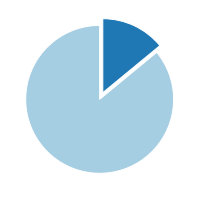

Proportion of cells selected by filter 1 for cell type 'CD14 mono' (out of all cells of this cell type)


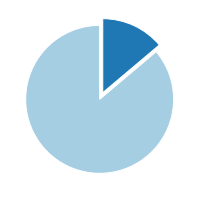

Proportion of cells selected by filter 1 for cell type 'DC' (out of all cells of this cell type)


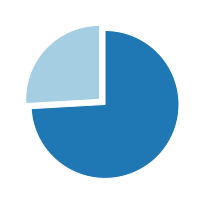

In [14]:
cell_types_by_filter = {0: ["CD14 mono", "Neutrophil", "PB"], 1: ["CD14 mono", "DC"]}

for f, cell_types in cell_types_by_filter.items():
    for ct in cell_types:
        print(f"Proportion of cells selected by filter {f} for cell type '{ct}' (out of all cells of this cell type)")
        ep.plot_selected_proportion(filter_response, "cell.type.coarse", ct, ratio_max_response=.3,
                                    filter_response_col=f"response_filter_{f}", palette="Paired",
                                    save=f"blish_severity_selected_proportion_filter_{f}_"
                                    f"{ct.replace('/','_').replace(' ', '_')}",
                                    out_dir=plot_dir)